# 0.0.Entendimento do projeto

**Objetivo do projeto, como ele sera resolvido e muitas outras informações contidas no arquivo PDS(Plano de Solução).**


**OBS:** Como realizei diversas análises e cálculos no notebook anterior e salvei os dados balanceados, decidir apenas deixar esse notebook com o enconder dos dados e assim por diante nos modelos de ML, será mais rápido e mais logico trabalhar assim.

# 1.0.Impots

In [85]:
#Manipulação de dados
import pandas as pd
import numpy as np
import sys , os
import joblib

#Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

#SQl
import sqlalchemy

#Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#Redes Neurais
import tensorflow as tf
from keras.layers import Dense, Dropout, activation
from keras.optimizers import Adam
from keras import Sequential

#Transformação dos dados
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

#Rebalanceamento de dados
from imblearn import combine as c

#Seleção das melhores colunas
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

# Estatística
import scipy
from scipy.stats import normaltest
from scipy.stats import chi2_contingency


#filterwarnings
import warnings
warnings.filterwarnings('ignore')

#Show all columns
pd.set_option('display.max_columns', None)

## 1.1.Funções de ajuda

In [2]:
sys.path.append(os.path.abspath(os.path.join('modulos')))

#Funções Gerais
from functions_help import data_dimensions,analise_descritiva_dos_dados

#Validação
from cross_validation import cross_validation_kfold_class

from visualization import sns_histplot


#Avaliar perfomance
from models_performance import model_perfomance_class

#Feature Selection
from feature_selection import selecao_univariada,eliminacao_recursiva_rfe, relevancia_iv, boruta_selection

# 2.0.Enconder dos dados

In [3]:
df2 = pd.read_feather('datasets/dados_balanceados.feather')
df2.head()

,credit_score,Tenure,Balance,num_of_products,isActiveMember,estimated_salary,geography,gender,age_cat,exited
0,612.0,1.0,0.00,1.0,1.0,83256.26,Spain,Male,29-38,1
1,601.0,1.0,64430.06,2.0,1.0,96517.97,France,Male,39-48,0
2,627.0,6.0,57809.32,1.0,0.0,188258.49,Germany,Female,29-38,0
3,745.0,10.0,96048.55,1.0,0.0,74510.65,Germany,Male,39-48,0
4,532.0,9.0,0.00,2.0,0.0,30583.95,France,Male,29-38,0


In [4]:
#Separando os dados entre numéricos e categoricos, pois será necessario para realizar as transformações

attributes_num = df2.select_dtypes(include=['int64','float64']).drop('exited',axis=1)
attibutes_cat  = df2.select_dtypes(include=['object'])

col_num = attributes_num.columns.tolist()
col_cat = attibutes_cat.columns.tolist()

## 2.1.Fazendo Rescaling nos dados

**Rescaling escolhido: RobustScaler**

**Motivo:** Acredito que ele e o melhor, pois foi feito para lidar com grandes distribuições de dados, pegando os valores de quartil para realizar seus cálculos, assim sendo pouco influenciado para valor outliers nos dados.

In [5]:
rs = RobustScaler()

In [6]:
df2[col_num] = rs.fit_transform(df2[col_num].values)
df2.head(3)

,credit_score,Tenure,Balance,num_of_products,isActiveMember,estimated_salary,geography,gender,age_cat,exited
0,-0.304518,-1.00,-0.798963,0.0,0.720705,-0.181422,Spain,Male,29-38,1
1,-0.390407,-1.00,-0.298145,1.0,0.720705,-0.045743,France,Male,39-48,0
2,-0.187396,0.25,-0.349608,0.0,-0.279295,0.892843,Germany,Female,29-38,0


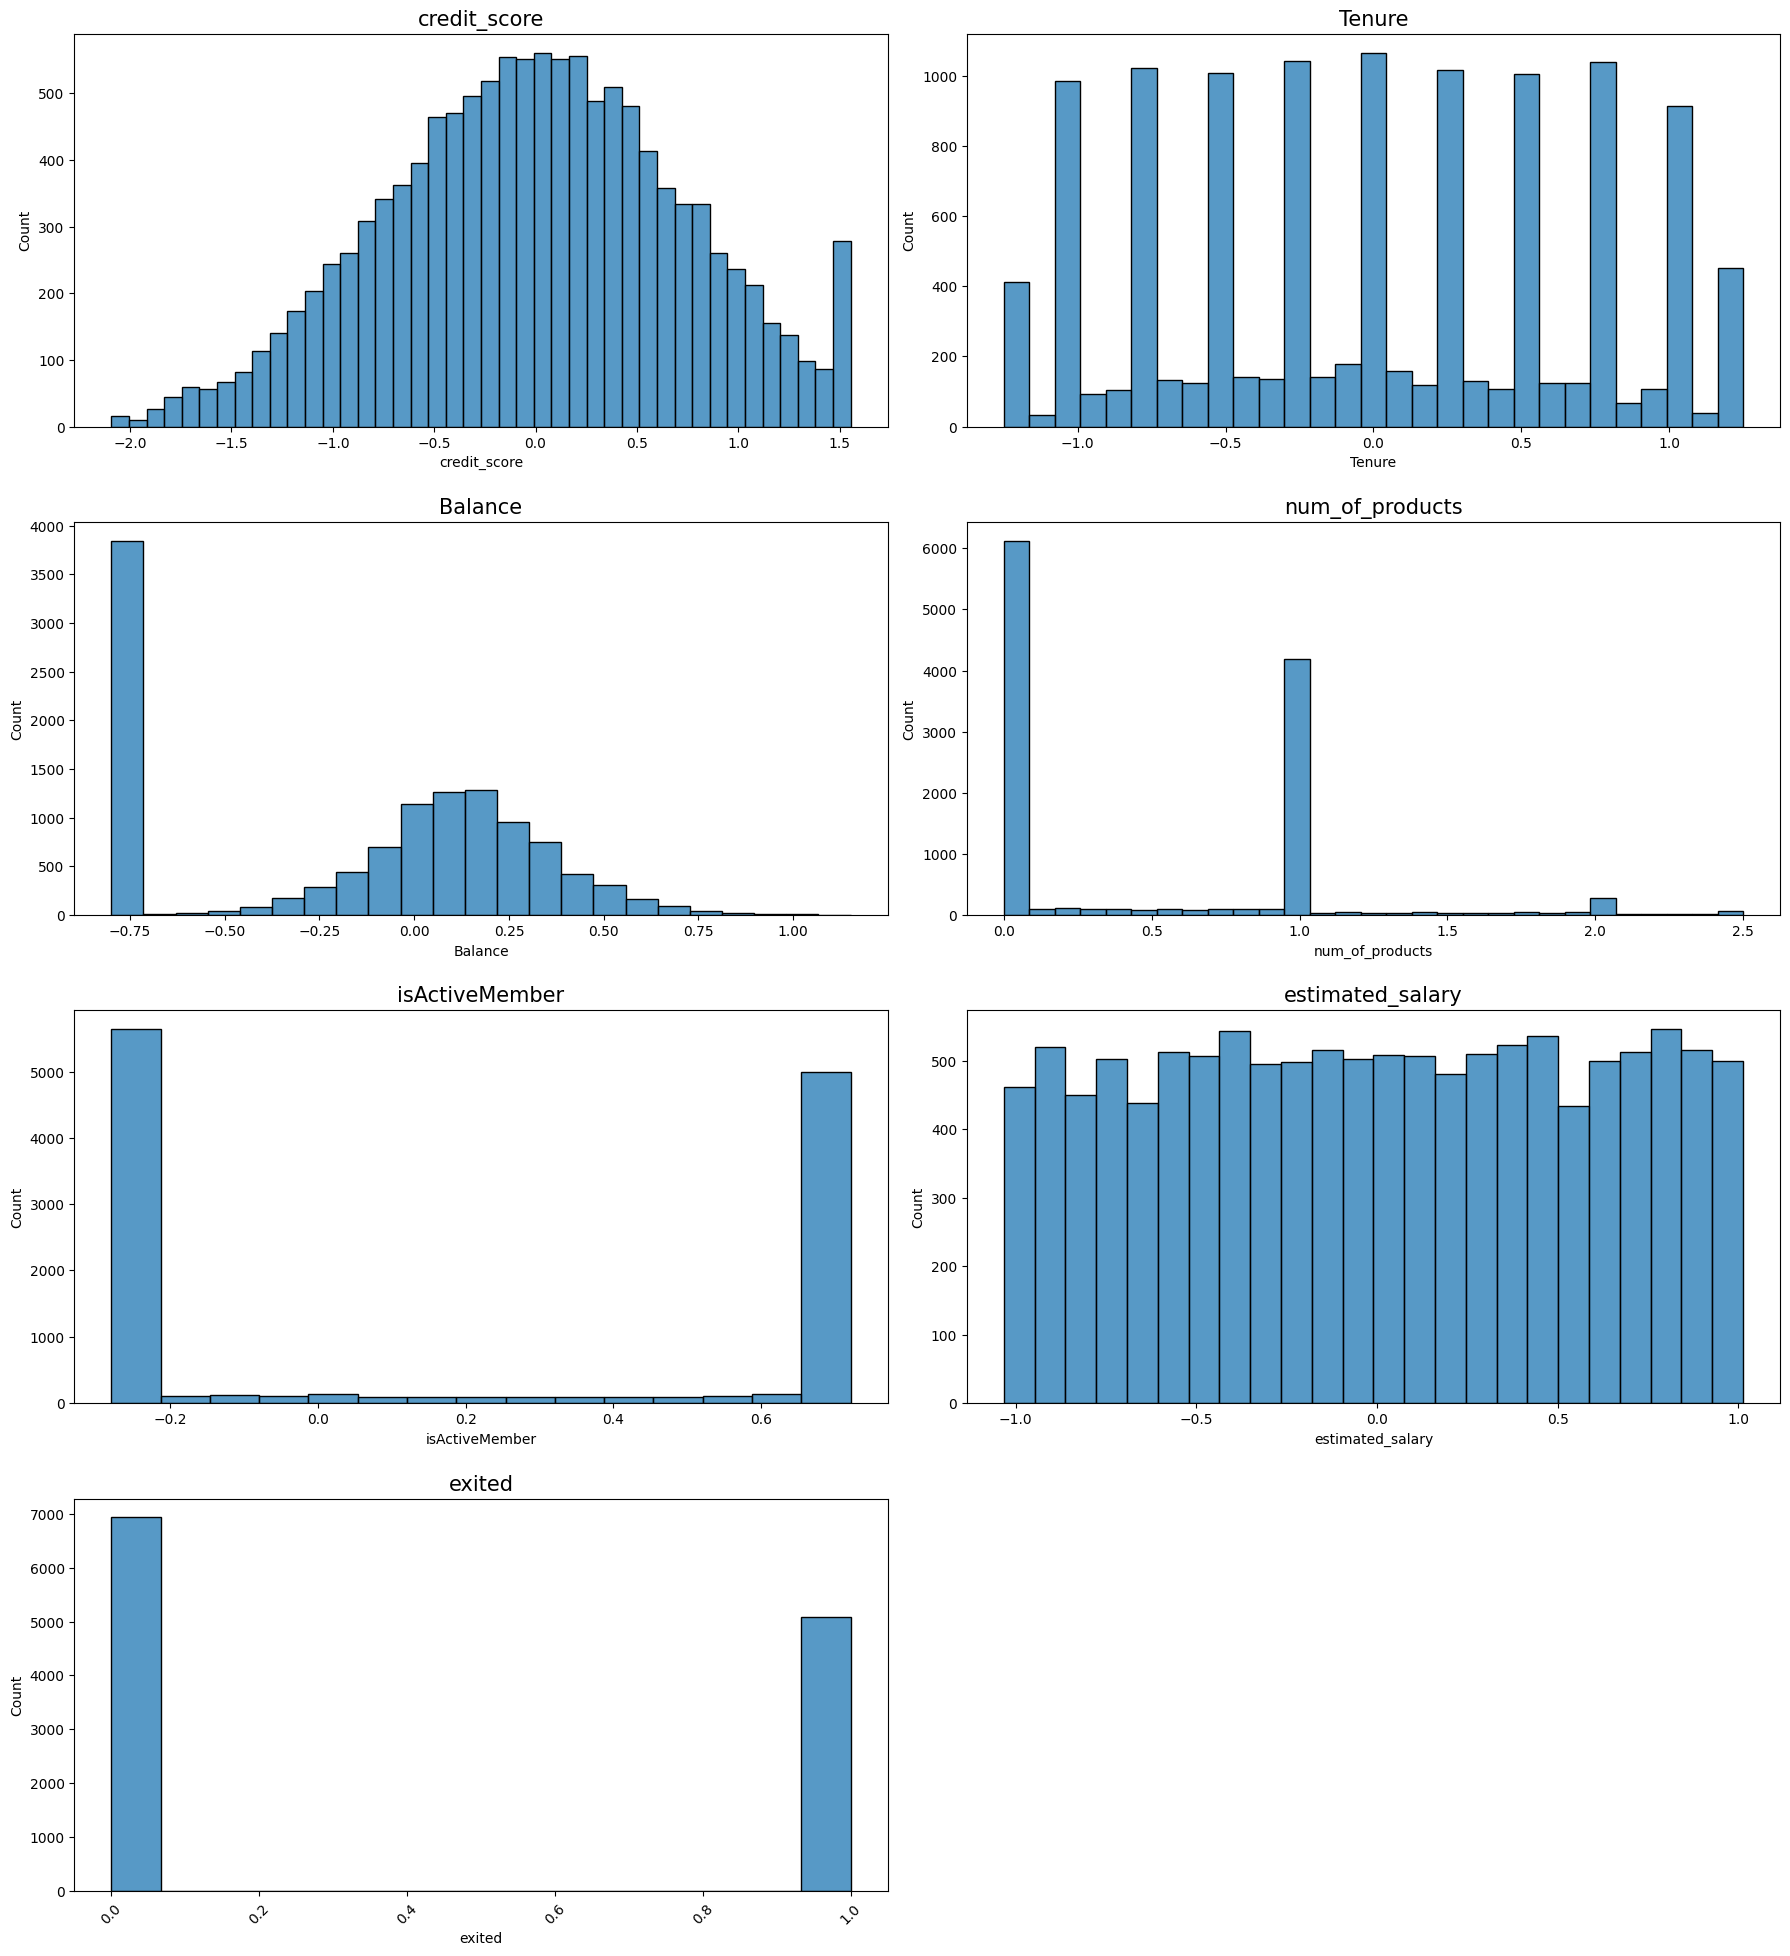

In [7]:
#Analisando a distribuição dos dados reescalados
sns_histplot(df2,df2.select_dtypes(include=['int64','float64']).columns.tolist())

## 2.2.Tratando as features categoricas.

**Metodo usado: Relevancia WOE**

**Motivo:** Usarei a relevância da predição da feature para substituir o valor dela, farei por que julgo ser o mais apropriado para os nossos dados, embora o One Hot não seja má ideia, acredito que a força preditora da variável pode me surpreender e me dar bons resultados. 

<Figure size 700x700 with 0 Axes>

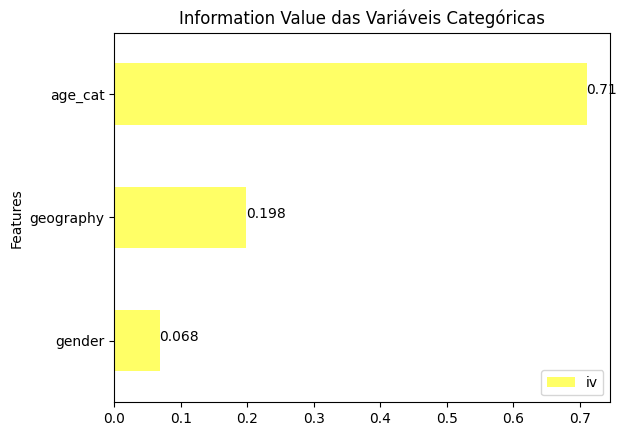

In [8]:
results = relevancia_iv(df2,col_cat,'exited')

In [9]:
#Relevancia de cada valor
results.reset_index().rename(columns={'index':'Feature'})[['Feature','woe']]

exited,Feature,woe
0,France,-0.305765
1,Germany,0.672271
2,Spain,-0.285178
3,Female,0.268062
4,Male,-0.256816
5,18-28,-1.186965
6,29-38,-0.852067
7,39-48,0.401472
8,49+,1.209181


In [10]:
df2['geography'] = df2['geography'].apply(lambda x: np.round(-0.30576518233901606,4) if x == 'France' else
                                 np.round(0.6722712456759936,4) if x == 'Germany' else np.round(0.-0.28517824850850665,4) )

df2['gender'] = df2['gender'].apply(lambda x: np.round(-0.2568164644490587,3) if x == 'Male' else np.round(0.26806228125338905,4))


df2['age_cat'] = df2['age_cat'].apply(lambda x: np.round(-1.1869652746964552,4) if x == '18-28' else
                                                 np.round(-0.8520671946724286,4) if x == '29-38' else
                                                 np.round(0.40147162830539146,4) if x == '39-48' else np.round(1.209180769346363,4))

# 3.0.Seleção de colunas
**Vou usar o Boruta como metodo de seleção de features**

**Motivo:** O Boruta usa um método para achar as colunas mais relevantes de uma forma muito espetacular, ele simplesmente cria um modelo para cada coluna e verifica se a coluna ajudou o modelo na performance ou não.

In [11]:
df3 = df2.copy()
df3.head()

,credit_score,Tenure,Balance,num_of_products,isActiveMember,estimated_salary,geography,gender,age_cat,exited
0,-0.304518,-1.00,-0.798963,0.0,0.720705,-0.181422,-0.2852,-0.2570,-0.8521,1
1,-0.390407,-1.00,-0.298145,1.0,0.720705,-0.045743,-0.3058,-0.2570,0.4015,0
2,-0.187396,0.25,-0.349608,0.0,-0.279295,0.892843,0.6723,0.2681,-0.8521,0
3,0.733966,1.25,-0.052373,0.0,-0.279295,-0.270897,0.6723,-0.2570,0.4015,0
4,-0.929170,1.00,-0.798963,1.0,-0.279295,-0.720305,-0.3058,-0.2570,-0.8521,0


In [12]:
X = df3.drop('exited',axis=1)
y = df3['exited']

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [14]:
dados_selecionados, dados_nao_selecionados = boruta_selection(df3,X_train,y_train,'exited',RandomForestClassifier)

In [15]:
dados_nao_selecionados.head(3)

,Tenure,gender,geography,exited
0,-1.00,-0.2570,-0.2852,1
1,-1.00,-0.2570,-0.3058,0
2,0.25,0.2681,0.6723,0


In [16]:
dados_selecionados.head(3)

,credit_score,Balance,num_of_products,isActiveMember,estimated_salary,age_cat,exited
0,-0.304518,-0.798963,0.0,0.720705,-0.181422,-0.8521,1
1,-0.390407,-0.298145,1.0,0.720705,-0.045743,0.4015,0
2,-0.187396,-0.349608,0.0,-0.279295,0.892843,-0.8521,0


In [17]:
X = dados_selecionados.drop('exited',axis=1)
y = dados_selecionados['exited']

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [19]:
X_train[:10]

,credit_score,Balance,num_of_products,isActiveMember,estimated_salary,age_cat
7363,-1.686560,-0.355767,1.000000,0.720705,-0.972771,-0.8521
8027,0.874513,-0.798963,0.000000,0.720705,-0.712234,-0.8521
6187,1.553821,-0.037278,1.000000,-0.279295,0.058336,0.4015
11614,-0.789708,0.319000,0.966804,-0.279295,0.413768,0.4015
10332,0.557503,0.158809,2.000000,0.720705,0.294330,1.2092
2110,-0.210820,-0.798963,1.000000,0.720705,0.871582,-0.8521
8862,-0.342375,-0.175866,0.000000,-0.279295,-0.833156,0.4015
2375,0.679309,0.282317,0.000000,-0.279295,0.418269,-0.8521
9148,-0.528620,0.139439,0.000000,-0.279295,-0.363834,1.2092
10775,0.432887,-0.003544,0.000000,-0.279295,0.787770,-0.8521


# 4.0.Machine Learning Models

## 4.1.LogisticRegression

In [20]:
lc = LogisticRegression(C=0.01)
lc.fit(X_train,y_train)

LogisticRegression(C=0.01)

## 4.2.Redes Neurais

In [21]:
#Preprando os dados de treino
ohe = OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
y_train_nn[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [22]:
#Preprando os dados de teste
y_test_nn = y_test.to_numpy()

In [23]:
#Modelo
modelo = Sequential()

modelo.add(Dense(30,input_dim=X_train.shape[1],kernel_initializer='normal',activation='relu'))
modelo.add(Dropout(0.5))
modelo.add(Dense(50,activation='relu',kernel_initializer='normal'))
modelo.add(Dropout(0.5))
modelo.add(Dense(2,kernel_initializer='normal',activation='softmax'))

opt = Adam()

#Compilando o modelo
modelo.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])


modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                210       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                1550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 1,862
Trainable params: 1,862
Non-trainable params: 0
_________________________________________________________________


In [24]:
#Treinando o modelo
historico = modelo.fit(X_train,y_train_nn,epochs=100,batch_size=100,verbose=1)

Epoch 1/100
85/85 [==============================] - 3s 3ms/step - loss: 0.6459 - acc: 0.6405
Epoch 2/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5810 - acc: 0.7119
Epoch 3/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5744 - acc: 0.7136
Epoch 4/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5690 - acc: 0.7221
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5624 - acc: 0.7242
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5621 - acc: 0.7286
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5534 - acc: 0.7320
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5488 - acc: 0.7375
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5462 - acc: 0.7371
Epoch 10/100
85/85 [==============================] - 0s 2ms/step - loss: 0.5429 - acc: 0.7390
Epoch 11/100
85/85 [==============================] - 0s 2m

85/85 [==============================] - 0s 2ms/step - loss: 0.4376 - acc: 0.8078
Epoch 88/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4379 - acc: 0.8076
Epoch 89/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4366 - acc: 0.8084
Epoch 90/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4350 - acc: 0.8075
Epoch 91/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4317 - acc: 0.8110
Epoch 92/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4335 - acc: 0.8085
Epoch 93/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4304 - acc: 0.8125
Epoch 94/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4384 - acc: 0.8085
Epoch 95/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4386 - acc: 0.8058
Epoch 96/100
85/85 [==============================] - 0s 2ms/step - loss: 0.4348 - acc: 0.8108
Epoch 97/100
85/85 [==============================] - 0s 2ms/st

## 4.3.LGBM Classifier

In [25]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)

LGBMClassifier()

## 4.4.Random Forest Classifier

In [26]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

## 4.5.XGB Classifier

In [27]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

# 5.0.Models Perfomance

## 5.1.Simple Performance

### 5.1.1.Logistic Regression

Previsões erradas sobre o Total
1017 / 3605


Accuracy: 71.79%
Balacend Acurracy: 70.33%
Kappa Score: 41.28%
AUC: 0.7033

               precision    recall  f1-score   support

           0       0.74      0.80      0.77      2085
           1       0.69      0.61      0.65      1520

    accuracy                           0.72      3605
   macro avg       0.71      0.70      0.71      3605
weighted avg       0.72      0.72      0.72      3605



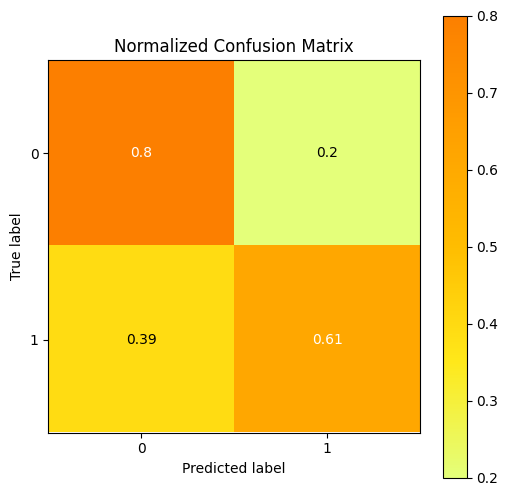

In [28]:
results_lc = lc.predict(X_test)
model_perfomance_class(y_test,results_lc,show=True)

### 5.1.2.Redes Neurais

In [29]:
previsoes_rnn = modelo.predict(X_test)
yhat_nn = ohe.inverse_transform(previsoes_rnn)
yhat = yhat_nn.reshape(1,-1)[0]
model_perfomance_class(y_test_nn,yhat)

113/113 [==============================] - 0s 1ms/step
Previsões erradas sobre o Total
681 / 3605


Accuracy: 81.11%
Balacend Acurracy: 79.43%
Kappa Score: 60.32%
AUC: 0.7943

               precision    recall  f1-score   support

           0       0.80      0.90      0.85      2085
           1       0.84      0.69      0.75      1520

    accuracy                           0.81      3605
   macro avg       0.82      0.79      0.80      3605
weighted avg       0.81      0.81      0.81      3605



### 5.1.3.LGBM

Previsões erradas sobre o Total
516 / 3605


Accuracy: 85.69%
Balacend Acurracy: 84.69%
Kappa Score: 70.28%
AUC: 0.8469

               precision    recall  f1-score   support

           0       0.85      0.91      0.88      2085
           1       0.86      0.78      0.82      1520

    accuracy                           0.86      3605
   macro avg       0.86      0.85      0.85      3605
weighted avg       0.86      0.86      0.86      3605



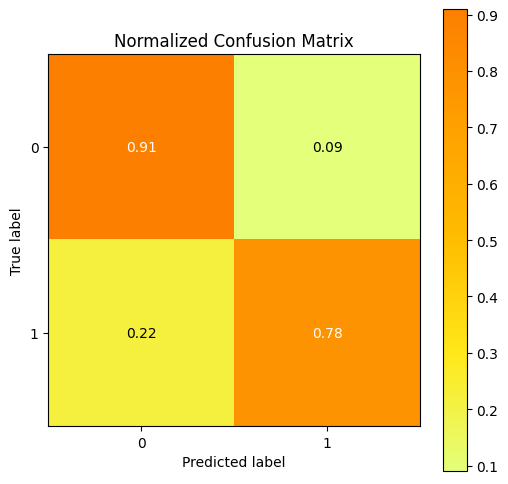

In [30]:
previsoes_lgbm = lgbm.predict(X_test)
model_perfomance_class(y_test,previsoes_lgbm,show=True)

### 5.1.4.Random Forest

Previsões erradas sobre o Total
459 / 3605


Accuracy: 87.27%
Balacend Acurracy: 86.56%
Kappa Score: 73.69%
AUC: 0.8656

               precision    recall  f1-score   support

           0       0.87      0.91      0.89      2085
           1       0.87      0.82      0.84      1520

    accuracy                           0.87      3605
   macro avg       0.87      0.87      0.87      3605
weighted avg       0.87      0.87      0.87      3605



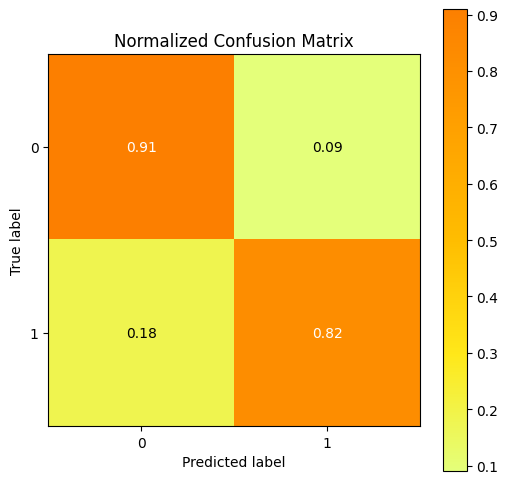

In [31]:
previsoes_rfc = rfc.predict(X_test)
model_perfomance_class(y_test,previsoes_rfc,show=True)

### 5.1.5.Xgb

Previsões erradas sobre o Total
494 / 3605


Accuracy: 86.30%
Balacend Acurracy: 85.47%
Kappa Score: 71.63%
AUC: 0.8547

               precision    recall  f1-score   support

           0       0.86      0.91      0.88      2085
           1       0.86      0.80      0.83      1520

    accuracy                           0.86      3605
   macro avg       0.86      0.85      0.86      3605
weighted avg       0.86      0.86      0.86      3605



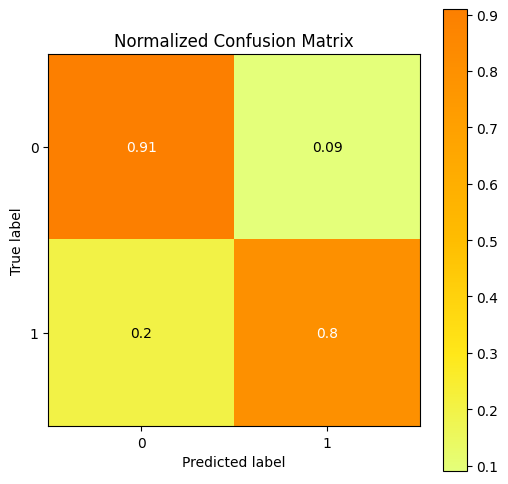

In [32]:
previsoes_xgb = xgb.predict(X_test)
model_perfomance_class(y_test,previsoes_xgb,show=True)

## 5.2.Cross Validation Performance


### 5.2.1.Logistic Regression

In [33]:
lc_cv = LogisticRegression(C=0.01)
cross_validation_kfold_class('LogisticRegression',lc_cv,10,X_train,y_train,verbose=True)

Folds: 1/10
Folds: 2/10
Folds: 3/10
Folds: 4/10
Folds: 5/10
Folds: 6/10
Folds: 7/10
Folds: 8/10
Folds: 9/10
Folds: 10/10


,Model Name,acurracy_score,Balacend_Acurracy,Kappa_Score,AUC
0,LogisticRegression,72.00%+/- 1.00%,71.00%+/- 1.00%,42.00%+/- 0.00%,71.00%+/- 1.00%


### 5.2.2.LGBM Classifier

In [34]:
lgbm_cv = LGBMClassifier()
cross_validation_kfold_class('LGBM Classifier',lgbm_cv,10,X_train,y_train,verbose=True)

Folds: 1/10
Folds: 2/10
Folds: 3/10
Folds: 4/10
Folds: 5/10
Folds: 6/10
Folds: 7/10
Folds: 8/10
Folds: 9/10
Folds: 10/10


,Model Name,acurracy_score,Balacend_Acurracy,Kappa_Score,AUC
0,LGBM Classifier,87.00%+/- 1.00%,86.00%+/- 1.00%,73.00%+/- 0.00%,86.00%+/- 1.00%


### 5.2.3Random Forest Classifier

In [35]:
rfc_cv = RandomForestClassifier()
cross_validation_kfold_class('Random Forest Classifier',rfc_cv,10,X_train,y_train,verbose=True)

Folds: 1/10
Folds: 2/10
Folds: 3/10
Folds: 4/10
Folds: 5/10
Folds: 6/10
Folds: 7/10
Folds: 8/10
Folds: 9/10
Folds: 10/10


,Model Name,acurracy_score,Balacend_Acurracy,Kappa_Score,AUC
0,Random Forest Classifier,88.00%+/- 1.00%,87.00%+/- 1.00%,74.00%+/- 0.00%,87.00%+/- 1.00%


### 5.2.4.XGB Classifier

In [36]:
xgb_cv = XGBClassifier()
cross_validation_kfold_class('XGB Classifier',xgb_cv,10,X_train,y_train,verbose=True)

Folds: 1/10
Folds: 2/10
Folds: 3/10
Folds: 4/10
Folds: 5/10
Folds: 6/10
Folds: 7/10
Folds: 8/10
Folds: 9/10
Folds: 10/10


,Model Name,acurracy_score,Balacend_Acurracy,Kappa_Score,AUC
0,XGB Classifier,87.00%+/- 1.00%,86.00%+/- 1.00%,73.00%+/- 0.00%,86.00%+/- 1.00%


### Resultado

**Modelo Escolhido:** Vou escolher seguir em frente com o modelo **Random Forest Classifier**

**Motivo:** E um modelo com uma exelente perfomance, rápido e tenho uma função de tunning feita para esse modelo, por isso vou seguir em frente com ele para a etapa de tunning.

# 6.0.Tunning do modelo escolhido

**Resultado:** Após aplicar um tunning do modelo, modificando vários parâmetros, percebi que os parâmetros padrão deles são os melhores, nenhum modelo do tunning foi superior ao padrão, por isso seguirei com o modelo padrão da random forest.

Previsões erradas sobre o Total
450 / 3605


Accuracy: 87.52%
Balacend Acurracy: 86.82%
Kappa Score: 74.21%
AUC: 0.8682

               precision    recall  f1-score   support

           0       0.88      0.91      0.89      2085
           1       0.87      0.82      0.85      1520

    accuracy                           0.88      3605
   macro avg       0.87      0.87      0.87      3605
weighted avg       0.88      0.88      0.87      3605



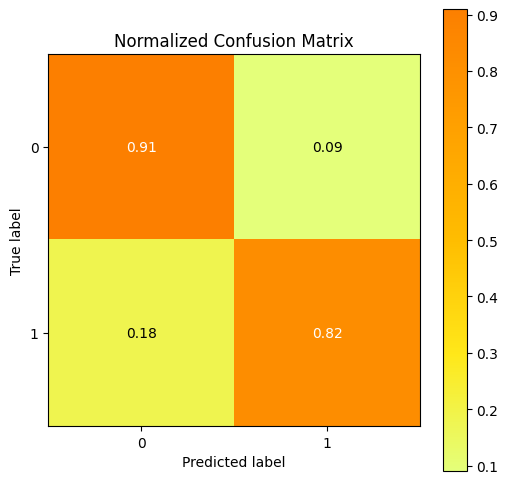

In [84]:
random_class = RandomForestClassifier(n_estimators=1200,random_state=42) #Pelo visto um pequeno aumento no numero de estimators melhora o modelo.
random_class.fit(X_train,y_train)
model_perfomance_class(y_test,random_class.predict(X_test),show=True)

In [86]:
#Salvando o modelo
joblib.dump(random_class,open('modelo/custumer_churn_random_forest_class.joblib','wb'))

**O que foi feito nessa etapa?**
- Machine Learning Models:
    - Essa e uma etapa de teste que visa encontrar o melhor modelo que se adéque aos meus dados, para isso testei diversos modelos e até redes neurais, e encontrei o melhor modelo com uma performance de 87%, um excelente resultado.
    
**O que será feito na próxima etapa?**
- Interpretação do erro:
    - Analisarei o comportamento do erro, analisar graficamente como ele esta distribuído o cliente churn, comparar com o real e analisar a distribuição  do erro.

    - Caso houvesse alguma feature numérica de valor nos dados, eu poderia analisar o quanto o modelo trará de lucro para a empresa, porem como e um projeto de classificação não sera possível.

**Próxima etapa:**
Interpretação do erro